In [1]:
import numpy as np
import numba as nb
import pandas as pd
import re
import os
from utils.tsea import enrich_score,permutation,taxonomy_set_enrichment_analysis
import networkx as nx

In [51]:
output_path = '/home/bruce1996/data/MCI/fig/revigo/'

In [15]:
humann_path = pd.read_csv("/home/bruce1996/data/MCI/raw_data/humann_output/probiotics_humann_result.txt",sep='\t',index_col=0)
humann_go = pd.read_csv("/home/bruce1996/nvme2/probiotics_humann_go.tsv",sep='\t',index_col=0)
humann_path.columns = [x.split('-')[0] for x in humann_path.columns]
humann_path.index.name = None
humann_go.columns = [x.split('-')[0] for x in humann_go.columns]
humann_go.index.name = None

In [4]:
metaphlan_output = "/home/bruce1996/data/MCI/metaphlan_result/formated_mci_metaphlan_table.txt"
meta_df = pd.read_csv(metaphlan_output,sep = '\t',index_col=0)
meta_df.columns = [x.split('_')[0] for x in meta_df.columns]

metadata = pd.read_csv("/home/bruce1996/data/MCI/metadata/diagnosis_with_consensus.txt",sep = '\t',index_col=0)
meta_df = meta_df.loc[:,metadata.index]

In [5]:
from matplotlib import cm,colors
cluster_color = dict()
cmap = cm.get_cmap('Set2', 8) 
n = 1
for i in range(cmap.N):    
    if n < 6 :
        rgba = cmap(i)
        # rgb2hex accepts rgb or rgba
        color = colors.rgb2hex(rgba)
        cluster_color[n] = color
        n+=1
    else : break
    
metadata['color'] = metadata['Lactobacillus_cluster'].map(cluster_color)

### utlis

In [13]:
from sklearn.preprocessing import StandardScaler

def format_humann_output(humann_result) :
    #remove unintegrated
    idx = [bool(re.search('UN',x)) == False for x in humann_result.index]
    humann_result = humann_result.loc[idx,:].copy()
    pathway = [x.split('|')[0] for x in humann_result.index]
    humann_result['pathway'] = pathway
    pathway_df = humann_result.groupby('pathway').agg('sum')
    pathway_df.index.name = None
    return humann_result,pathway_df

def format_2_tsea(humann_df,pathway_df) :
    path = list(pathway_df)
    path_component = dict()
    for i in range(humann_df.shape[0]) :
        header = humann_df.index[i]
        p = header.split('|')[0]
        component = header.split('.')[-1]
        if p in path_component.keys() :
            path_component[p].append(component)
        else :
            path_component[p] = [component]        
    return path_component

def metaphlan_2_zscore(meta_df) :
    '''
    mata_df : dataframe; row is species, column is sample
    '''
    x = meta_df.to_numpy().T
    scalar = StandardScaler()
    z_score = scalar.fit_transform(x).T
    zscore_df = pd.DataFrame(z_score,index = meta_df.index,columns=meta_df.columns)
    return zscore_df


In [4]:
from scipy.stats import mannwhitneyu
def wilconox_ranksum_test(data,metadata,pos_label) :
    '''
    data : dataframe,row is feature , column as sample
    '''
    pvalue = np.zeros(data.shape[0],dtype = np.float16)
    for i in range(data.shape[0]) :
        f = data.iloc[i,:]
        pos_idx = np.where(metadata == pos_label,True,False)
        pos = f[pos_idx]
        negative = f[~pos_idx]
        U1, p = mannwhitneyu(pos, negative)
        pvalue[i] = p

    return pvalue

def edit_revigo(file) :
    df = pd.read_csv(file,sep ='\t')
    df = df.fillna('Other')
    tmp = list(set(df['Representative']))
    reps = [x for x in tmp if x == x]
    for i in range(df.shape[0]) :
        name = df['Name'][i]
        if name in reps :
            df['Representative'][i] = name
    filename = file.split('.')[0]
    df.to_csv(filename + '.input',sep=',',index=False)

In [6]:
import glob
files = glob.glob('/home/bruce1996/nvme2/revigo_output/Normal/*.txt')
for f in files :
    print(f)
    edit_revigo(f)

/home/bruce1996/nvme2/revigo_output/Normal/Revigo_BP_TreeMap_c1.txt
/home/bruce1996/nvme2/revigo_output/Normal/Revigo_MF_TreeMap_c1.txt
/home/bruce1996/nvme2/revigo_output/Normal/Revigo_MF_TreeMap_c2.txt
/home/bruce1996/nvme2/revigo_output/Normal/Revigo_BP_TreeMap_c2.txt
/home/bruce1996/nvme2/revigo_output/Normal/Revigo_MF_TreeMap_c3.txt
/home/bruce1996/nvme2/revigo_output/Normal/Revigo_BP_TreeMap_c3.txt
/home/bruce1996/nvme2/revigo_output/Normal/Revigo_BP_TreeMap_c4.txt
/home/bruce1996/nvme2/revigo_output/Normal/Revigo_MF_TreeMap_c4.txt


/tmp/ipykernel_1439583/2425579155.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Representative'][i] = name


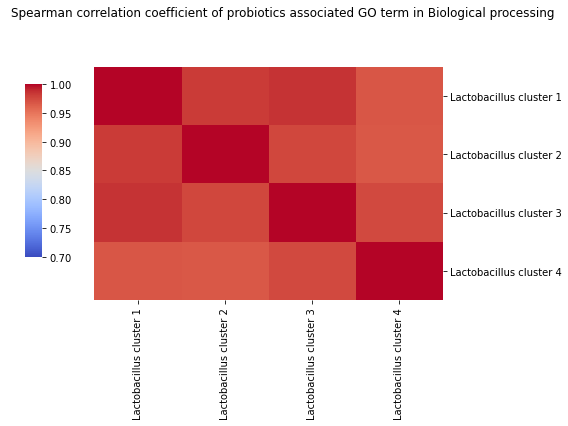

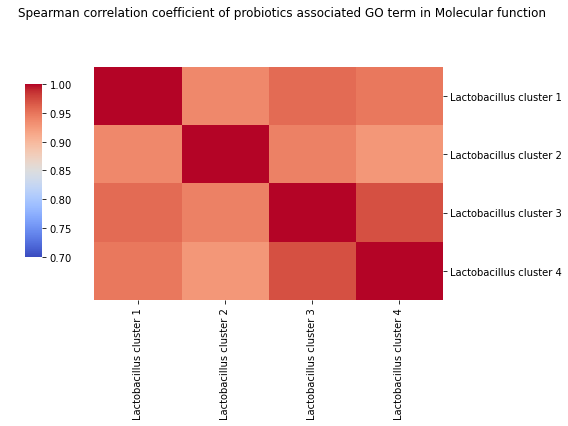

In [3]:
from scipy.stats import spearmanr
import seaborn as sns 

literature_go_df = pd.read_csv('/home/bruce1996/data/MCI/probiotics_involved_GO/literature_go_metadata.txt',sep= '\t',index_col=0)
prefix = '/home/bruce1996/data/MCI/result/normal/revigo_input/literature_based_cluster'
tail = '_normal.txt'
mf_corr = np.zeros([4,4])
bp_corr = np.zeros([4,4])
for i in range(4) :
    for j in range(4) :
        df1 = pd.read_csv(prefix + str(i+1) + tail,sep='\t',index_col=0)
        df1 = df1.loc[literature_go_df.index,:]
        df2 = pd.read_csv(prefix + str(j+1) + tail,sep='\t',index_col=0)
        df2 = df2.loc[literature_go_df.index,:]

        mf_idx = np.where(literature_go_df['Field'] == 'MF',True,False)
        bp_idx = np.where(literature_go_df['Field'] == 'BP',True,False)

        mf_corr[i,j] = spearmanr(df1.loc[mf_idx,'Abundance'].values,df2.loc[mf_idx,'Abundance'].values)[0]
        bp_corr[i,j] = spearmanr(df1.loc[bp_idx,'Abundance'].values,df2.loc[bp_idx,'Abundance'].values)[0]


index = ['Lactobacillus cluster ' +str(x) for x in range(1,5)]
cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)
plot_df = pd.DataFrame(bp_corr,index = index, columns=index)

g = sns.clustermap(plot_df, cmap="coolwarm",vmin=0.7, vmax=1,  cbar_kws={"shrink": .3},
                row_cluster=False, 
                col_cluster=False,
                linewidths=0, figsize=(8, 6))
g.ax_cbar.set_position((0.05, .4, .03, .4))
g.fig.suptitle('Spearman correlation coefficient of probiotics associated GO term in Biological processing ')
output_path = '/home/bruce1996/data/MCI/result/normal/revigo_corr/'
if os.path.exists(output_path) == False :
    os.mkdir(output_path)
g.savefig(output_path + 'spearman_matrix_of_lacto_cluster_bp_normal.svg',bbox_inches = 'tight',format = 'svg')


plot_df = pd.DataFrame(mf_corr,index = index, columns=index)

g = sns.clustermap(plot_df, cmap="coolwarm",vmin=0.7, vmax=1,  cbar_kws={"shrink": .3},
                row_cluster=False, 
                col_cluster=False,
                linewidths=0, figsize=(8, 6))
g.ax_cbar.set_position((0.05, .4, .03, .4))
g.fig.suptitle('Spearman correlation coefficient of probiotics associated GO term in Molecular function ')
g.savefig(output_path + 'spearman_matrix_of_lacto_cluster_mf_normal.svg',bbox_inches = 'tight',format = 'svg')

### permanova

In [31]:
from skbio import DistanceMatrix
from skbio.stats.ordination import pcoa    

matrix = pd.read_csv("/home/bruce1996/data/MCI/metaphlan_result/weighted_unifrac_distance_matrix.txt",sep = '\t',index_col=0)
matrix.columns = [x.split('_')[0] for x in matrix.index]
matrix.index = [x.split('_')[0] for x in matrix.index]

matrix = matrix.loc[metadata.index,metadata.index]
# Load the pandas matrix into skbio format
dm = DistanceMatrix(matrix)

ref : https://matplotlib.org/stable/gallery/statistics/confidence_ellipse.html <br>

In [8]:
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)
    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

In [14]:
from skbio.stats.ordination import pcoa  
from skbio.stats.distance import permanova,DistanceMatrix
import matplotlib.pyplot as plt
import seaborn as sns

def pcoa_scatterplot(dmatrix,metadata,hue,title,output_path,style=None) :
    '''
    dmatrix : dataframe, distance matrix with index & columns
    metadata : dataframe, row as sample ,columns as feature
    '''
    x = dmatrix.to_numpy()
    pcoa_r = pcoa(x,number_of_dimensions=2)
    pcoa_df = pcoa_r.samples
    pcoa_df.index = dmatrix.index
    pc1_exp,pc2_exp = round(100*pcoa_r.proportion_explained,2)
    pcoa_df = pd.concat([pcoa_df,metadata],axis=1)

    plt.figure(figsize=(8,6))
    if style != None :
        sns.scatterplot(data=pcoa_df,x= 'PC1',y='PC2',hue=hue,style='Diagnosis',palette="Set2",s=100)
    else :
        sns.scatterplot(data=pcoa_df,x= 'PC1',y='PC2',hue=hue,palette="Set2")

    xlabel = "PCoA1 (" + str(pc1_exp) + "%)"
    ylabel = "PCoA2 (" + str(pc2_exp) + "%)"
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(bbox_to_anchor=(1.1, 1))
    plt.title(title)
    plt.savefig(output_path,dpi = 300,bbox_inches = 'tight')

def mds_scatterplot(dmatrix,metadata,hue,title,output_path,style=None) :
    '''
    dmatrix : dataframe, distance matrix with index & columns
    metadata : dataframe, row as sample ,columns as feature
    '''
    x = dmatrix.to_numpy()
    mds = MDS(n_components=2,dissimilarity='precomputed')
    mds_r = mds.fit_transform(x)
    mds_df = pd.DataFrame(mds_r,index = dmatrix.index)
    mds_df.columns = ['MDS1','MDS2']
    mds_df = pd.concat([mds_df,metadata],axis=1)

    plt.figure(figsize=(8,6))
    if style != None :
        sns.scatterplot(data=mds_df,x= 'MDS1',y='MDS2',hue=hue,style='Diagnosis',palette="Set2",s=100)
    else :
        sns.scatterplot(data=mds_df,x= 'MDS1',y='MDS2',hue=hue,palette="Set2")

    plt.legend(bbox_to_anchor=(1.1, 1))
    plt.title(title)
    plt.savefig(output_path,dpi = 300,bbox_inches = 'tight')

def pcoa_with_permanova_scatterplot(dmatrix,metadata,hue,condition,title,output_path,color = ['#66c2a5','#fc8d62']) :
    '''
    dmatrix : dataframe, distance matrix with index & columns
    metadata : dataframe, row as sample ,columns as feature
    '''
    x = dmatrix.to_numpy()
    pcoa_r = pcoa(x,number_of_dimensions=2)
    pcoa_df = pcoa_r.samples
    pcoa_df.columns = ['PC1','PC2']
    pcoa_df.index = dmatrix.index
    pc1_exp,pc2_exp = round(100*pcoa_r.proportion_explained,2)
    ###centroid
    #centroid for first condition
    c1_idx = np.where(metadata[hue] == condition[0],True,False)
    x1= pcoa_df.loc[c1_idx,'PC1'].values
    y1 = pcoa_df.loc[c1_idx,'PC2'].values
    c2_idx = np.where(metadata[hue] == condition[1],True,False)
    x2= pcoa_df.loc[c2_idx,'PC1'].values
    y2 = pcoa_df.loc[c2_idx,'PC2'].values
    ###permanova
    m = DistanceMatrix(dmatrix,ids=dmatrix.index)
    perm_r = permanova(m,metadata,hue,permutations= 10000)
    pvalue = perm_r['p-value']
    text_pos = pcoa_df.mean().values
    text = 'Permanova p-value : ' + str(round(pvalue,3))
    #plot 
    pcoa_df = pd.concat([pcoa_df,metadata],axis=1)
    plt.figure(figsize=(8,6))
    ax = plt.gca()
    sns.scatterplot(data=pcoa_df,x= 'PC1',y='PC2',hue=hue,palette=color)
    text_x = min(pcoa_df['PC1'])
    text_y = max(pcoa_df['PC2'])
    plt.text(text_x,text_y,text)
    
    #plot centroid & ellipse for condition 1
    confidence_ellipse(x1, y1, ax, edgecolor=color[0],n_std=3)
    ax.scatter(np.mean(x1), np.mean(y1), c=color[0], s=100)
    #plot centroid & ellipse for condition 2
    confidence_ellipse(x2, y2, ax, edgecolor=color[1],n_std=3)
    ax.scatter(np.mean(x2), np.mean(y2), c=color[1], s=100)

    xlabel = "PCoA1 (" + str(pc1_exp) + "%)"
    ylabel = "PCoA2 (" + str(pc2_exp) + "%)"
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.savefig(output_path,dpi = 300,bbox_inches = 'tight',format = 'svg')

/home/bruce1996/anaconda3/lib/python3.9/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.1981732572104398 and the largest is 4.040726104019744.
  warn(
/home/bruce1996/anaconda3/lib/python3.9/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenval

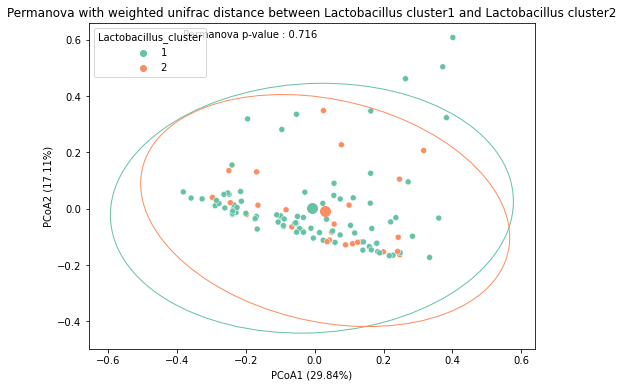

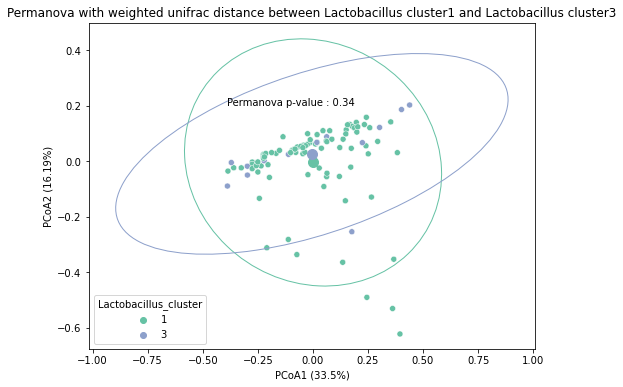

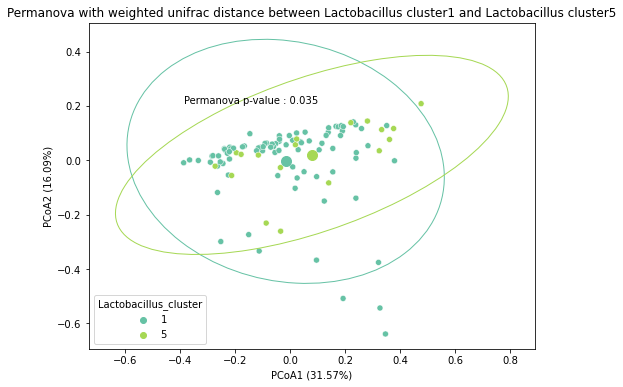

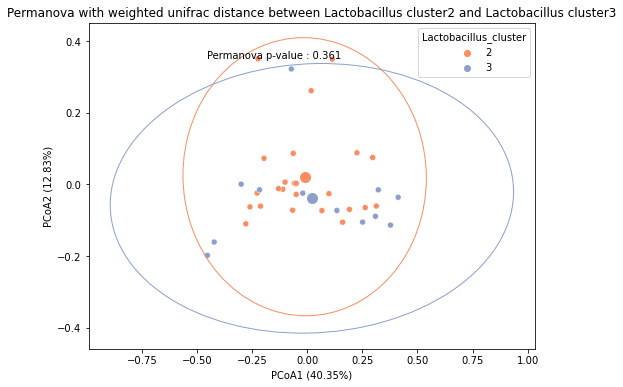

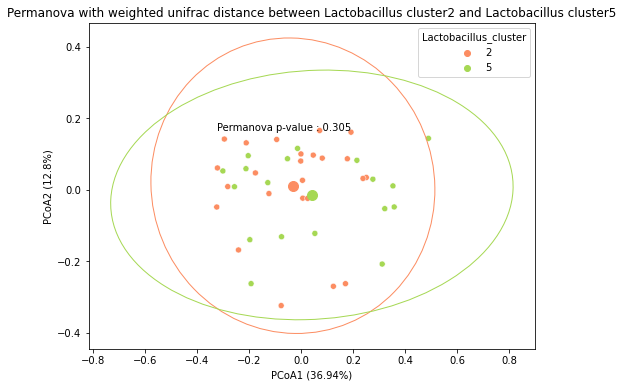

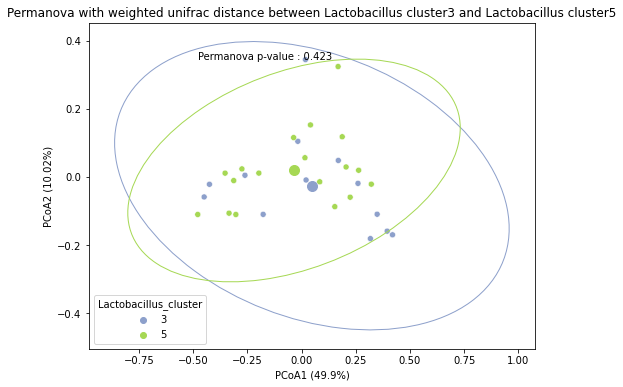

In [38]:
from itertools import combinations
cb = list(combinations([1,2,3,5],2))
diagnosis = 'Normal'
hue = 'Lactobacillus_cluster'
prefix = hue.split('_')[0]

dia_idx = np.where(metadata['Diagnosis'] == diagnosis,True,False)
plot_matrix = matrix.loc[dia_idx,dia_idx]
plot_metadata = metadata.loc[dia_idx,:]

for i in range(len(cb)) :
    condition = cb[i]
    color = [cluster_color[x] for x in condition]
    idx = np.where((plot_metadata[hue] == condition[0]) | (plot_metadata[hue] == condition[1]),True,False)
    m = plot_matrix.loc[idx,idx]
    label = plot_metadata.loc[idx,:]
    title = "Permanova with weighted unifrac distance between " + prefix +" cluster"+ str(condition[0]) + ' and '+prefix + ' cluster' + str(condition[1])
    file = output_path + 'permanova_' + prefix + '_' + 'c' +str(condition[0]) + '_c' + str(condition[1])+ '_' + diagnosis + '.svg' 
    pcoa_with_permanova_scatterplot(m,label,hue=hue,condition=condition,color= color,title=title,output_path=file)


### Lefse

In [5]:
lefse = pd.read_csv("/home/bruce1996/nvme2/probiotics_lefse/lefse.res",sep = '\t',index_col=0,header = None)
lefse.columns = ['kruskalwallis','class','LDA score','wilconox']
idx = lefse['class'].isnull() == False
lefse_df = lefse.loc[idx,['class','LDA score']]
lefse_df.index.name = None
lefse_df = lefse_df.sort_values(by='class',ascending=True)
lefse_df['color'] = lefse_df['class'].map(cluster_color)
lefse_df['species'] = list(lefse_df.index)
lefse_df = lefse_df.sort_values(by=['class','species'])
lefse_df['class'] = [str(x) for x in lefse_df['class'].values]

In [10]:
from math import log10
meta = meta_df.loc[lefse_df.index,:].copy()
prevalence = lambda x : (sum(x > 0) / len(x)) * 100
pv = list(map(prevalence,meta.to_numpy()))
mab = list(map(log10,meta.mean(axis=1).values))

In [14]:
plot_df = lefse_df.loc[:,['class','color','species']].copy()
plot_df['Prevalence'] = pv
plot_df['log10 mean abundance'] = mab

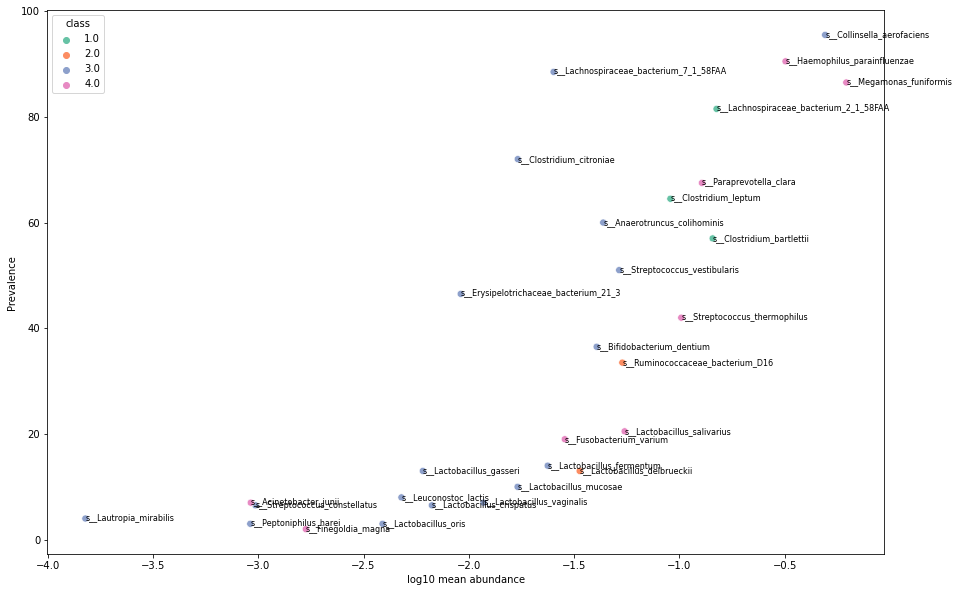

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

output_dir = "/home/bruce1996/data/pr/0912/"
plt.figure(figsize=(15,10))
sns.scatterplot(data=plot_df,x='log10 mean abundance',y = 'Prevalence',hue = 'class',palette=['#66c2a5','#fc8d62','#8da0cb','#e78ac3'],s = 50)

s = plot_df['species']
x = plot_df['log10 mean abundance']
y = plot_df['Prevalence']
for i in range(plot_df.shape[0]) :
    plt.text(x[i],y[i],s[i],fontsize = 8,horizontalalignment='left',verticalalignment='center')
plt.savefig(output_dir + 'lefse_scatterplot.png',dpi = 300)

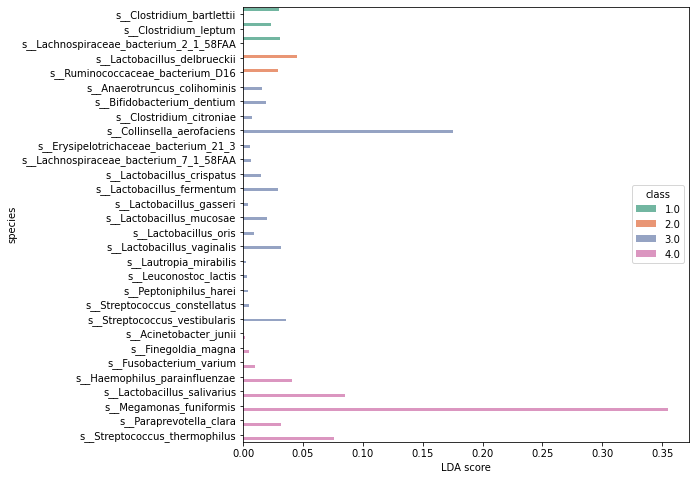

In [220]:
plt.figure(figsize=(8,8))
sns.barplot(data= lefse_df,x = 'LDA score',y = 'species',hue = 'class',palette=[cluster_color[x] for x in range(1,5)],orient='h')
plt.savefig(output_dir + "lefse.png",bbox_inches = 'tight')

### Probiotics involved go tsea

In [10]:
def remove_go_by_level(go_list,go_graph,go2namespace,l_threshold=5) :
    validated_go = list()
    for go in go_list :
        if go in go2namespace.keys() :
            field = go2namespace[go]
            graph = go_graph[field]
            level = graph.nodes[go]['Level']
            if level >= l_threshold :
                validated_go.append(go)
    return validated_go

In [14]:
import pickle
import json

graph_d = dict()
graph_path = '/home/bruce1996/data/GO/networkx/'
go_field = ['biological_process','cellular_component','molecular_function']
for field in go_field :
    file = graph_path + field + '.go'
    with open(file , 'rb') as f:  # notice the r instead of w
        graph_d[field] = pickle.load(f)

file = '/home/bruce1996/data/GO/go2namespace.json'
with open(file, "r") as outfile:
    go2namespace = json.load(outfile)

humann_df,pathway_df = format_humann_output(humann_go)

NameError: name 'humann_go' is not defined

In [16]:
humann_df,pathway_df = format_humann_output(humann_go)
com_dict = format_2_tsea(humann_df,pathway_df)
output_path = "/home/bruce1996/nvme2/probiotics_tsea/"

probiotics_involved = list()
for k in com_dict.keys() :
    for c in com_dict[k] :
        if c in meta_df.index:
            if c not in probiotics_involved :
                probiotics_involved.append(c)

probiotics_df = meta_df.loc[probiotics_involved,:]
meta_z_df = metaphlan_2_zscore(probiotics_df)


for i in range(1,5) :
    sample_idx = consensus_cluster['cluster'] == i
    probiotics_z = meta_z_df.loc[:,sample_idx]
    ranking = list(probiotics_z.mean(axis=1).sort_values().index)
    ##tsea
    path_tsea = taxonomy_set_enrichment_analysis(com_dict,ranking)

NameError: name 'consensus_cluster' is not defined

### Candidate GO from literature

In [6]:
import glob

files = glob.glob('/home/bruce1996/data/MCI/probiotics_involved_GO/*.txt')
literature_go = pd.DataFrame()
for f in files :
    df = pd.read_csv(f,sep='\t',index_col=0)
    df.columns = ['Description']
    compound = f.split('/')[-1].split('.')[0] 
    df['component'] = [compound] * df.shape[0]
    literature_go = pd.concat([literature_go,df])

In [7]:
go_list = []
description = []
component = []

for go in np.unique(literature_go.index) :
    idx = np.where(literature_go.index == go)[0]
    go_list.append(go)
    description.append(literature_go['Description'].values[idx[0]])
    c = literature_go['component'].values[idx[0]]
    for c_idx in idx :
        if c_idx != idx[0] :
            c = c + ',' + literature_go['component'].values[c_idx]
    component.append(c)
literature_df = pd.DataFrame({'Description' : description,'Component' : component},index=go_list)


In [17]:
humann_df,pathway_df = format_humann_output(humann_go)
com_dict = format_2_tsea(humann_df,pathway_df)
output_path = "/home/bruce1996/nvme2/probiotics_tsea/"

candidate_go = set(literature_df.index).intersection(pathway_df.index)
literature_candidate_go = literature_df.loc[candidate_go,:]
component_dict = dict()
for i in range(literature_candidate_go.shape[0]) :
    c = literature_candidate_go['Component'][i]
    g = literature_candidate_go.index[i]
    if c in component_dict.keys() :
        component_dict[c].append(g)
    else :
        component_dict[c] = [g]

In [21]:
df = pd.read_csv('/home/bruce1996/data/MCI/result/MCI/consensus/lacto_sig_cluster.txt',sep = '\t')

In [26]:
pathway_df.columns = [x.split('_')[0] for x in pathway_df.columns]
pathway_df = pathway_df.loc[:,metadata.index]

In [32]:
label = pd.read_csv('/home/bruce1996/data/MCI/result/normal/consensus/lacto_sig_cluster.txt',sep = '\t')
pathway_df.columns = [x.split('_')[0] for x in pathway_df.columns]
pathway_df = pathway_df.loc[:,metadata.index]
path_df = pathway_df.loc[:,label.index]

candidate_go = set(literature_df.index).intersection(pathway_df.index)
literature_candidate_go = literature_df.loc[candidate_go,:]
diagnosis = 'normal'

for i in range(1,5) :
    cluster_idx = np.where(label['cluster'] == i,True,False)
    df = literature_candidate_go.copy()
    df['Abundance'] = path_df.loc[df.index,cluster_idx].mean(axis=1)
    #col = ['Abundance','Description','Component']
    df = df.loc[:,'Abundance']
    df.to_csv('/home/bruce1996/data/MCI/result/normal/revigo_input/literature_based_' + 'cluster' + str(i) + '_' + diagnosis + '.txt',sep ='\t')